In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.special import erfinv
from scipy.optimize import minimize
from matplotlib.colors import LinearSegmentedColormap, Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from pathlib import Path
figures_dir = Path("figures")
figures_dir.mkdir(parents=True, exist_ok=True)  # creates "figures" if missing

plt.style.use('./traffic_figures.mplstyle')
num_robots_palette = sns.color_palette("magma_r")

In [ ]:
# Generate plots for
# Main Text Fig. 2 of "Noise-Enabled Goal Attainment in Crowded Collectives"

data_dir = '../simulation_data/'
sim_name = 'fig2_simulation_data'
df_file_name = data_dir + sim_name + ".txt"

time_cutoff = 6000
end_time = 8000

# # Read DataFrames back into Python (Allows us to skip running the cells where we read in and use df and sweep_df!)
# # Can be uncommented after these csvs have been saved by later cells in this notebook
# goalsreached = pd.read_csv(data_dir + f'goalsreached_{sim_name}.csv')
# df_phase_diagram = pd.read_csv(data_dir + f'df_phase_diagram_{sim_name}.csv')

## Theoretical Prediction for Optimal $n, \sigma$

In [21]:
def ext(sigma):
    return np.exp(sigma**2 / 2)

def sigmastar(N, L, fov_range, fov_angle, step_length, cruise_speed):
    return (np.pi / 4 + fov_angle / 2) / (np.sqrt(2) * erfinv(1 - (np.pi**2 * fov_range**3 * N**(3/2)) / (8 * 0.3826 * L**3)))


def avg_dist_to_goal(sigma, L):
    return 0.3826 * L * ext(sigma)

def avg_collisions_per_goal(N, sigma, L, fov_range, fov_angle, step_length, cruise_speed):
    density = (N - 1) / L**2
    num_steps = avg_dist_to_goal(sigma, L) / step_length
    area_per_step = (fov_angle / (2 * np.pi)) * np.pi * fov_range**(2) + np.sqrt(2) * step_length * 2 * fov_range * np.sin(fov_angle / 2)
    
    return density * num_steps * area_per_step

def time_per_interaction(N, sigma, L, fov_range, fov_angle, step_length, cruise_speed):
    p_good_turn = (1-erf(fov_angle / (2 * np.sqrt(2) *  sigma))**2)

    avg_steps_per_interaction = 1/p_good_turn
    return avg_steps_per_interaction * step_length / cruise_speed

def time_per_swarm_goal(N, sigma, L, fov_range, fov_angle, step_length, cruise_speed):
    robot_time_per_goal = avg_dist_to_goal(sigma, L) / cruise_speed + avg_collisions_per_goal(N, sigma, L, fov_range, fov_angle, step_length, cruise_speed) * time_per_interaction(N, sigma, L, fov_range, fov_angle, step_length, cruise_speed)

    return robot_time_per_goal / N # the swarm is N times faster than the individual robot

def min_time_per_swarm_goal(N, L, fov_range, fov_angle, step_length, cruise_speed):
    sigma = sigmastar(N, L, fov_range, fov_angle, step_length, cruise_speed)
    return time_per_swarm_goal(N, sigma, L, fov_range, fov_angle, step_length, cruise_speed)


In [22]:
# Known values
L = 40
fov_range = 2 
fov_angle = 2 * np.pi / 3 
fov_angle_over_2pi = fov_angle/(2 * np.pi)
cruise_speed = 0.5
dt = 0.1
runsteps = 10
step_length = cruise_speed * runsteps * dt

# Initial guess for N
N0 = np.array([0.1])  # Start with an initial guess

# Call the minimize function
result = minimize(min_time_per_swarm_goal, N0, args=(L, fov_range, fov_angle, step_length, cruise_speed), bounds=[(10, 100)])

# Print the results
print("Optimization success:", result.success)
print("Optimal value of N:", result.x[0])
print("Minimum value of the function (Minimum time per swarm goal found):", result.fun)
# print("Optimization message:", result.message)

optimal_N = result.x[0]
optimal_sigma = sigmastar(optimal_N, L, fov_range, fov_angle, step_length, cruise_speed)
print("Optimal noise:", optimal_sigma)


Optimization success: True
Optimal value of N: 50.90422053286498
Minimum value of the function (Minimum time per swarm goal found): 1.7588617114757528
Optimal noise: 1.261763128402934


## Read in Simulation Data

In [23]:
# loading the largest data file takes about a minute

try:
    goalsreached
except NameError:
    df = pd.read_csv(df_file_name, index_col = False)
    df.columns = df.columns.str.strip()

    # end_time = np.max(df['sim_time'])
    sim_time_per_trial = end_time # 10 min = 600 seconds
    df['goal_age'] = (df['sim_time'] - df['goal_birth_time']) / end_time
    df['sim_time'] = np.round(df["sim_time"], 4)
    df['robot_id'] = df['robot_id'].astype('int')
    df

## Counting Goal Attainment

In [24]:
try:
    goalsreached
except NameError:
    # filter for desired columns and sim times, also drop duplicates
    goalsreached = df[(df['sim_time'].isin([time_cutoff, end_time])) & (df['noise'] != "unif") & (df['noise'] != -1)][['trial', 'periodic', 'num_robots', 'noise', 'sim_time', 'robot_id', 'goals_reached']].drop_duplicates()
    # pivot so that the different times now form different columns
    goalsreached = goalsreached.pivot(index=['trial', 'periodic', 'num_robots', 'noise', 'robot_id'], columns='sim_time', values='goals_reached').reset_index() # cast data for two times into two separate columns

    # goals reached per second in late portion of simulation (steady state)
    goalsreached['latesim_goals'] = (goalsreached[end_time] - goalsreached[time_cutoff])

    # sum goals reached over all robots in a trial
    goalsreached_trial = goalsreached.groupby(['trial', 'noise', 'num_robots', 'periodic'], observed=False).agg(goals_reached_trial = (end_time, 'sum'), 
                                                                                                                latesim_goals_trial = ('latesim_goals', 'sum')).reset_index()

    # now average over trials
    goalsreached = goalsreached_trial.groupby(['noise', 'num_robots', 'periodic'], observed=False).agg(avg_goals_reached = ('goals_reached_trial', 'mean'), 
                                                                                                    avg_latesim_goals = ('latesim_goals_trial', 'mean'), 
                                                                                                    var_latesim_goals =  ('latesim_goals_trial', 'var')).reset_index()

    # extra columns
    goalsreached['latesim_goal_rate'] = goalsreached['avg_latesim_goals'] / (end_time - time_cutoff)
    goalsreached['time_per_goal'] = (end_time - time_cutoff) / goalsreached['avg_latesim_goals'] 
    goalsreached['time_per_goal_per_robot'] = (end_time - time_cutoff) / goalsreached['avg_latesim_goals'] / goalsreached['num_robots']

    goalsreached.to_csv(data_dir + f'goalsreached_{sim_name}.csv', index=False)

    goalsreached

In [25]:
latesim_pivot = goalsreached[goalsreached["periodic"] == 1].pivot(index="num_robots", columns="noise", values='latesim_goal_rate')


In [26]:
"""
Map continuous (n, sigma) values to row/column positions on the latesim_pivot
heatmap grid.

If the pivot index/columns are evenly spaced, return fractional positions
(for interpolation) based on the spacing. Otherwise, snap to the nearest
existing index/column (using optimal_N for rows and rounded sigma for cols).
"""

def get_heatmap_position(n, sigma):
    # choose the best row position to represent n
    if len(np.unique(np.round(latesim_pivot.index.diff()[1:], 5))) == 1: # row index values evenly spaced
        row_index = (n - latesim_pivot.index[0]) / latesim_pivot.index.diff()[1]
    else:
        round_N = latesim_pivot.index[np.abs(latesim_pivot.index - optimal_N).argmin()]
        row_index = np.where(latesim_pivot.index == round_N)[0][0]

    # choose the best column position to represent sigma
    if len(np.unique(np.round(latesim_pivot.columns.diff()[1:], 5))) == 1: # columns evenly spaced
        col_index = (sigma - latesim_pivot.columns[0]) / latesim_pivot.columns.diff()[1]
    else:
        col_index = np.where(latesim_pivot.columns == np.round(sigma, 1))[0][0]

    return row_index, col_index

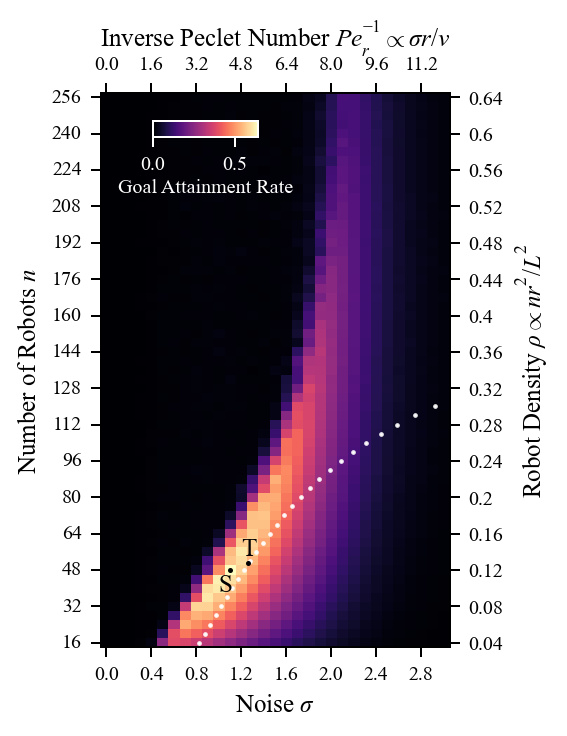

In [27]:
fig, ax1 = plt.subplots(figsize=(2.5, 4))

sns.heatmap(latesim_pivot, ax=ax1, 
            cmap="magma", 
            cbar = False)

# 🔲 Create an inset Axes inside `ax1` for the colorbar
cbar_ax = inset_axes(
    ax1, loc='upper left', width="30%", height="3%", # % of parent axis
    bbox_to_anchor=(0.15, -0.05, 1, 1),  # fine-tune position
    bbox_transform=ax1.transAxes,
    borderpad=0
)

# Manually set colorbar normalization
norm = plt.Normalize(vmin=latesim_pivot.min().min(), vmax=latesim_pivot.max().max())
sm = plt.cm.ScalarMappable(cmap="magma", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")

# Make colorbar labels and ticks white
cbar.ax.xaxis.set_tick_params(color='white')                             # white tick lines
plt.setp(cbar.ax.get_xticklabels(), color='white', fontsize=8)           # white tick labels
cbar.set_label("Goal Attainment Rate", color='white', fontsize=8,labelpad = 2)        # white label
cbar.outline.set_edgecolor('white')   

# Invert the y-axis
ax1.invert_yaxis()
small_tick_fontsize = 8

# Show every 4th tick
ax1.set_xticks(np.arange(0, len(latesim_pivot.columns), 4) + 0.5)
ax1.set_xticklabels(latesim_pivot.columns[::4], fontsize = small_tick_fontsize)

ax1.set_yticks(np.arange(0, len(latesim_pivot.index), 4) + 0.5)
ax1.set_yticklabels(latesim_pivot.index[::4], fontsize = small_tick_fontsize)

# Main x and y labels
ax1.set_xlabel('Noise $\sigma$')
ax1.set_ylabel('Number of Robots $n$')

# Create the secondary x-axis
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())  # Align x limits to synchronize tick positions

# Scale the secondary x-axis ticks by 2x
xticks = ax1.get_xticks()  # Assuming these ticks align with your data
xticks_scaled = np.round([float(ticklabel.get_text()) * fov_range / cruise_speed for ticklabel in ax1.get_xticklabels()], 1) # noise as dimensionless


ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks_scaled, fontsize = small_tick_fontsize)
ax2.set_xlabel('Inverse Peclet Number $Pe_r^{-1} \propto \sigma r / v$',)

# Create the secondary y-axis
ax3 = ax1.twinx()
ax3.set_ylim(ax1.get_ylim())  # Align y limits to synchronize tick positions

# Scale the secondary y-axis ticks by 2x
yticks = ax1.get_yticks()  # Assuming these ticks align with your data


yticks_scaled = np.round([fov_range **2 / L**2 * float(ticklabel.get_text()) for ticklabel in ax1.get_yticklabels()], 2) # density as dimensionless


ax3.set_yticks(yticks)
ax3.set_yticklabels(yticks_scaled, fontsize = small_tick_fontsize)
ax3.set_ylabel('Robot Density $\\rho \propto nr^2/L^2$',)

# Label optimal positions
for row_index, temp_n in enumerate(latesim_pivot.index):
    temp_ss = sigmastar(temp_n, L, fov_range, fov_angle, step_length, cruise_speed)
    if 0 <= temp_ss and temp_ss < np.max(np.unique(goalsreached['noise'])):
        # col_index = np.where(latesim_pivot.columns == np.round(temp_ss, 1))[0]
        (row_index, col_index) = get_heatmap_position(temp_n, temp_ss)
        plt.scatter(col_index + 0.5, row_index + 0.5, color="white", s = 0.8, alpha = 0.9)

text_color = 'black'
# Label T for theory optimum
(row_index, col_index) = get_heatmap_position(optimal_N, optimal_sigma)
plt.text(col_index + 0.5, row_index + 2.0, "T", color=text_color, ha='center', va='center') # Tweak annotation position so text is readable
plt.scatter(col_index + 0.5, row_index + 0.5, color=text_color, s = 1)


# Label simulation optimum
max_value = latesim_pivot.max().max()
max_col = np.where(latesim_pivot == max_value)[1] # This returns the column containing the max value
max_row = np.where(latesim_pivot == max_value)[0] # This returns the index (row label) of the max value in that column

plt.text(max_col + 0.1, max_row - 1.2, "S", color=text_color, ha='center', va='center') # Tweak annotation position so text is readable
plt.scatter(max_col + 0.5, max_row + 0.5, color=text_color, s = 1)


# Save figure
plt.savefig("figures/fig2_attainment_heatmap.png", dpi = 600, bbox_inches='tight')


## Plotting with Approximation

In [28]:
goalsreached['extension'] = ext(goalsreached['noise'])

In [29]:
goalsreached['time_per_goal_ana'] = time_per_swarm_goal(goalsreached['num_robots'], goalsreached['noise'], L, fov_range, fov_angle, step_length, cruise_speed)

/var/folders/_z/lqbfmt_n3cnf2ps65d8dctg40000gp/T/ipykernel_2862/543902731.py:2: RuntimeWarning: overflow encountered in exp
  return np.exp(sigma**2 / 2)


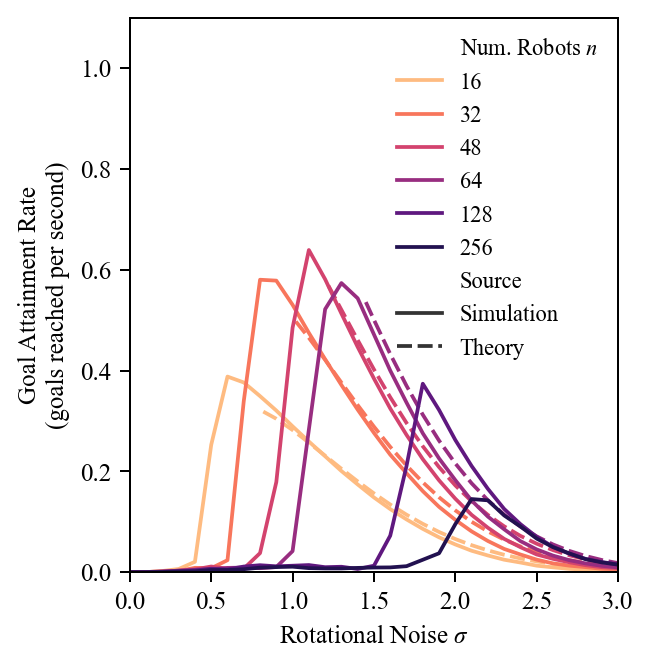

In [ ]:
temp_num_robots_arr = [16, 32, 48, 64, 128, 256] # [16, 44, 48, 52, 64, 128, 256]

# Make column for analytical predictions
goalsreached['goals_second_half_ana'] = (end_time - time_cutoff) / goalsreached['time_per_goal_ana']
goalsreached['goal_rate_second_half_ana'] = 1 / goalsreached['time_per_goal_ana']
    

# Convert to pandas DataFrame
df_sim = pd.DataFrame({
    'noise': goalsreached['noise'],
    '$n$': goalsreached['num_robots'],
    'latesim_goal_rate': goalsreached['latesim_goal_rate'],
    'Source': 'Simulation'
})

df_ana = pd.DataFrame({
    'noise': goalsreached['noise'],
    '$n$': goalsreached['num_robots'],
    'latesim_goal_rate': goalsreached['goal_rate_second_half_ana'],
    'Source': 'Theory'
})

# Add extra analytical data point for the sigma star location
temp_ns = np.unique(df_ana['$n$'])
temp_sigmastars = np.round(sigmastar(np.unique(df_ana['$n$']), L, fov_range, fov_angle, step_length, cruise_speed), 2)
df_ana_sigmastar = pd.DataFrame({
    'noise': temp_sigmastars,
    '$n$': temp_ns,
    'latesim_goal_rate': 1/ time_per_swarm_goal(temp_ns, temp_sigmastars, L, fov_range, fov_angle, step_length, cruise_speed),
    'Source': 'Theory'
})


combined_df = pd.concat([df_sim, df_ana, df_ana_sigmastar])

combined_df['sigmastar'] = np.round(sigmastar(combined_df['$n$'], L, fov_range, fov_angle, step_length, cruise_speed), 2)
combined_df.loc[combined_df['sigmastar'] < 0, 'sigmastar'] = np.inf # Set negative values (solve not defined) to infinity


combined_df['Num. Robots $n$'] = combined_df['$n$'].astype(str)


rainbow_colors = ['#d072ac', '#d78c7d', '#b8b26e', '#97d08f', '#95d9c7', '#b6d3f1']
rainbow_cmap = LinearSegmentedColormap.from_list('custom_rainbow', rainbow_colors)
num_robots_palette = sns.color_palette("magma_r")


if True:
    plt.figure(figsize=(3.5, 4)) # 12,3 for wide figure

    ax = sns.lineplot(data = combined_df[combined_df['$n$'].isin(temp_num_robots_arr)
                                         & ((combined_df['noise'] >= combined_df['sigmastar']) | (combined_df['Source']=='Simulation'))],
                      x = "noise",
                      y = "latesim_goal_rate",
                      hue = "Num. Robots $n$",
                      style = "Source",
                      palette = num_robots_palette,
                    #   errorbar='se',
                      alpha = 1)


    # plt.title('Goal Attainment Rate (Last ' + str(cutoff_pct) + '% of Simulation)')
    plt.xlabel("Rotational Noise $\sigma$")
    plt.ylabel('Goal Attainment Rate\n(goals reached per second)')
    plt.legend(loc='best')
    plt.xlim([0,3])
    plt.ylim([0, 1.1])

plt.savefig("figures/fig2_attainment_lineplot.pdf", bbox_inches='tight')


# Plotting Jam Phase Diagram

In [15]:
colors = ['#669bbc', '#e35053']  # Blue-gray (0: not blocked) and red (1: blocked)
my_cmap = LinearSegmentedColormap.from_list('custom_r_to_b', colors)

# jams at end
trial_num = 1
num_robots_list = [32, 64, 128, 256] # all robot nums
num_robots_list = sorted(num_robots_list, reverse=True)
noise_level_list = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5]

In [16]:
try:
    df_phase_diagram
except NameError:
    df_phase_diagram = df[
        df['num_robots'].isin(num_robots_list) &
        df['noise'].isin(noise_level_list) &
        (df['periodic'] == 1) &
        (df['sim_time'] == end_time) &
        (df['trial'] == trial_num)
    ]

    df_phase_diagram = df_phase_diagram[['trial', 'periodic', 'num_robots', 'noise', 'sim_time', 'robot_id', 'goals_reached', 'stopped', 'x_pos', 'y_pos', 'angle']].drop_duplicates()

In [17]:
# for periodic plots: make copies of the data so that periodic dots show up across borders
shifted_dfs = []
shifts = [-L, 0, L]
# Iterate over all combinations of x and y shifts
for x_shift in shifts:
    for y_shift in shifts:
        # Create a copy of the DataFrame
        df_shifted = df_phase_diagram.copy()
        
        # Apply the shifts
        df_shifted['x_pos'] = df_shifted['x_pos'] + x_shift
        df_shifted['y_pos'] = df_shifted['y_pos'] + y_shift
        
        # Append the shifted DataFrame to the list
        shifted_dfs.append(df_shifted)

# Concatenate all DataFrames in the list
df_phase_diagram = pd.concat(shifted_dfs, ignore_index=True)

cols = len(noise_level_list)
rows = len(num_robots_list)


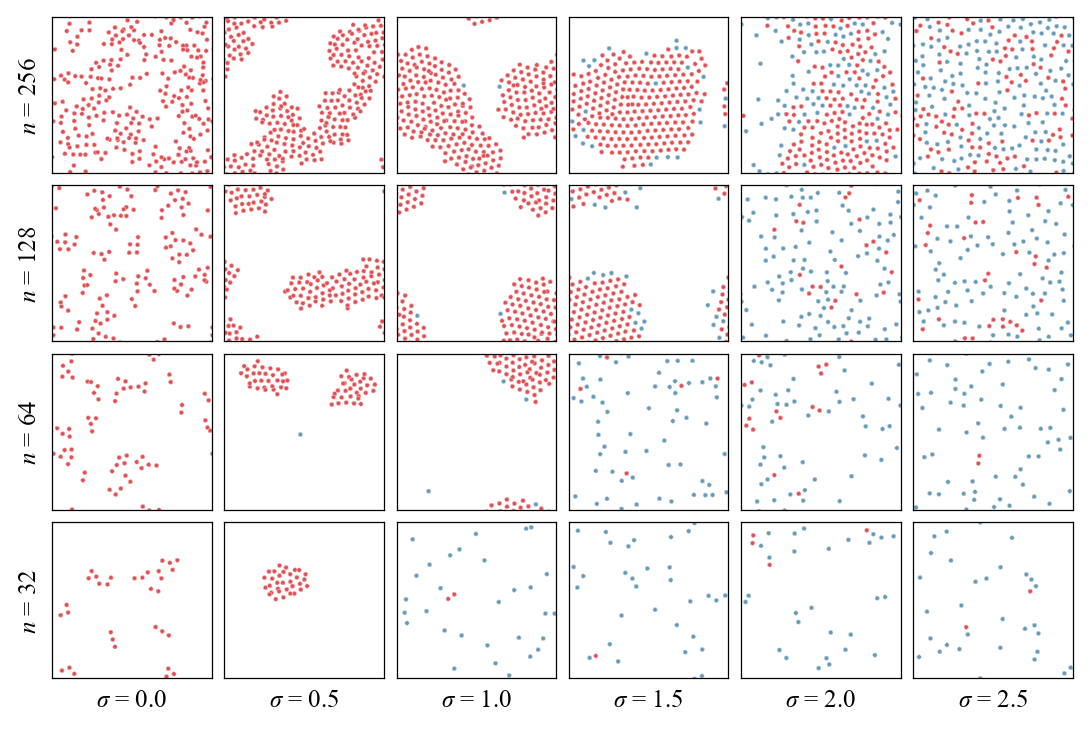

In [18]:
g = sns.FacetGrid(df_phase_diagram, col="noise", row="num_robots", margin_titles=False, 
                    row_order=num_robots_list,
                    height=1, aspect=1)

# Create a scatterplot in each facet
g.map_dataframe(
    sns.scatterplot,
    'x_pos', 'y_pos', hue='stopped', palette=my_cmap, hue_norm=(0,1),
    s=3
)

# Tick marks off, subplot borders on
for ax in g.axes.flat:
    ax.tick_params(axis='both', which='both', bottom=False, top=False,
                    left=False, right=False, labelbottom=False, labelleft=False)
    padding = 0.08
    ax.set_xlim([-L/2 - padding, L/2 + padding])
    ax.set_ylim([-L/2, L/2])

    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
        spine.set_visible(True)

# Set custom axis labels
for i, ax in enumerate(g.axes[:, 0]):
    ax.set_ylabel(f"$n$ = {num_robots_list[i]}")
for i, ax in enumerate(g.axes[-1, :]):
    ax.set_xlabel(f"$\sigma$ = {noise_level_list[i]}")

g.set_titles("")
g.tight_layout(pad=0.5)


plt.savefig("figures/fig2_endoftrial_phasediagram.png", bbox_inches='tight', dpi = 600)


In [19]:
df_phase_diagram.to_csv(data_dir + f'df_phase_diagram_{sim_name}.csv', index=False)